In [52]:
import tifffile as tiff
import numpy as np

def get_image_metadata(image_path):
    with tiff.TiffFile(image_path) as tif:
        image_metadata = {}
        image_metadata['filename'] = tif.filename
        image_metadata['is_tiled'] = any(page.is_tiled for page in tif.pages)
        image_metadata['is_bigtiff'] = tif.is_bigtiff
        
        # Extract metadata from the first page
        page = tif.pages[0]
        image_metadata['shape'] = page.shape
        image_metadata['dtype'] = page.dtype.name
        
        # Extract compression, photometric, and bits per sample if they exist
        if hasattr(page, 'compression'):
            image_metadata['compression'] = str(page.compression)
        if hasattr(page, 'photometric'):
            image_metadata['photometric'] = str(page.photometric)
        if hasattr(page, 'bitspersample'):
            image_metadata['bits_per_sample'] = page.bitspersample
        else:
            # Use tags to get bits per sample if not directly available
            if 'BitsPerSample' in page.tags:
                image_metadata['bits_per_sample'] = page.tags['BitsPerSample'].value
        
        # Check for common tags
        common_tags = ['ImageDescription', 'Artist', 'Software', 'DateTime', 'ResolutionUnit', 'XResolution', 'YResolution']
        for tag in common_tags:
            if tag in page.tags:
                image_metadata[tag] = page.tags[tag].value
        
        # Collect all other tags
        image_metadata['tags'] = {tag.name: tag.value for tag in page.tags.values() if tag.name not in common_tags}

        # Multipage TIFF info
        image_metadata['number_of_pages'] = len(tif.pages)

        return image_metadata

# Example usage
image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
metadata = get_image_metadata(image_path)
for key, value in metadata.items():
    print(f'{key}: {value}')


filename: P288_73669012104-F5_016_040_DAPI.tif
is_tiled: False
is_bigtiff: False
shape: (134, 183)
dtype: uint16
compression: COMPRESSION.NONE
photometric: PHOTOMETRIC.MINISBLACK
bits_per_sample: 16
Software: DIPlib with dipIO
ResolutionUnit: 2
XResolution: (1, 1)
YResolution: (1, 1)
tags: {'ImageWidth': 183, 'ImageLength': 134, 'BitsPerSample': 16, 'Compression': <COMPRESSION.NONE: 1>, 'PhotometricInterpretation': <PHOTOMETRIC.MINISBLACK: 1>, 'StripOffsets': (8, 8060, 16112, 24164, 32216, 40268, 48320), 'RowsPerStrip': 22, 'StripByteCounts': (8052, 8052, 8052, 8052, 8052, 8052, 732), 'PlanarConfiguration': <PLANARCONFIG.CONTIG: 1>, 'SampleFormat': <SAMPLEFORMAT.UINT: 1>}
number_of_pages: 1


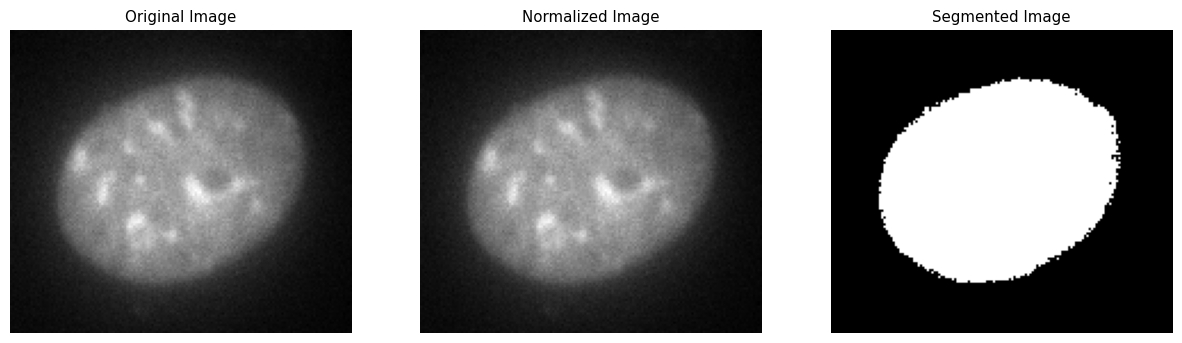

In [161]:
import tifffile as tiff
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Function to read and preprocess the TIFF image
def preprocess_image(image_path):
    # Read the image using tifffile
    image = tiff.imread(image_path)
    # Normalize the image to improve visibility
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # Flatten the image for clustering
    flat_image = normalized_image.flatten().reshape(-1, 1)
    return image, flat_image, normalized_image

# Function to apply K-means clustering to the image
def apply_kmeans(flat_image, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(flat_image)
    clustered = kmeans.labels_
    return clustered

# Function to visualize the clustered image
def visualize_clusters(image, clustered, n_clusters):
    # Reshape the clustered labels back to the original image shape
    clustered_image = clustered.reshape(image.shape)
    # Create a colored version of the clustered image for better visibility
    colored_clustered_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    colors = np.linspace(0, 255, n_clusters).astype(np.uint8)
    for i in range(n_clusters):
        colored_clustered_image[clustered_image == i] = [colors[i]] * 3
    return colored_clustered_image

# Main function to process the image and detect foci
def detect_foci(image_path, n_clusters=2):
    image, flat_image, normalized_image = preprocess_image(image_path)
    clustered = apply_kmeans(flat_image, n_clusters)
    segmented_image = visualize_clusters(image, clustered, n_clusters)
    
    # Display the original, normalized, and segmented images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title('Normalized Image')
    plt.imshow(normalized_image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title('Segmented Image')
    plt.imshow(segmented_image)
    plt.axis('off')
    
    plt.show()

# Example usage
# image_path = 'BPS-Microscopy/train/P244_73665165741-C8_017_024_proj.tif'
# image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
image_path = 'BPS-Microscopy/DAPI_MASK_images/P251_73665707362-C7_002_010_DAPI.tif'
detect_foci(image_path, n_clusters=2)

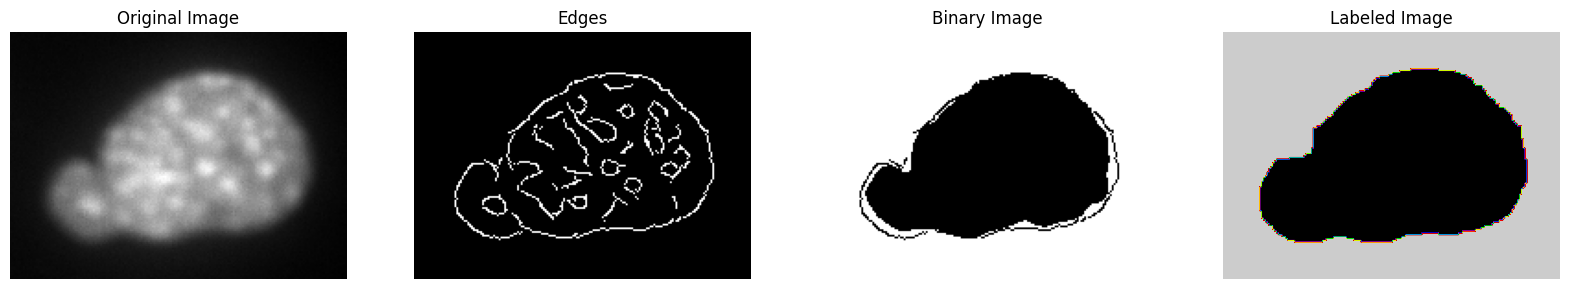

Number of foci detected: 1


In [42]:
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

# Function to read and preprocess the TIFF image
def preprocess_image(image_path):
    # Read the image using tifffile
    image = tiff.imread(image_path)
    # Normalize the image to improve visibility
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return normalized_image

# Function to apply Otsu's thresholding and count foci
def count_foci_otsu_with_edges(image_path):
    image = preprocess_image(image_path)
    
    # Apply GaussianBlur to reduce noise and improve thresholding
    blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
    
    # Apply Canny edge detection with adjusted thresholds
    edges = cv2.Canny(blurred_image, 25, 75)
    
    # Combine edges with the original image
    combined = cv2.addWeighted(blurred_image, 0.5, edges, 0.5, 0)
    
    # Apply Otsu's thresholding
    _, binary_image = cv2.threshold(combined, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Invert the binary image to make foci white and background black
    binary_image = cv2.bitwise_not(binary_image)
    
    # Apply morphological operations to separate overlapping foci with adjusted kernel size and iterations
    kernel = np.ones((3, 3), np.uint8)
    morphed_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=3)
    morphed_image = cv2.morphologyEx(morphed_image, cv2.MORPH_CLOSE, kernel, iterations=3)
    morphed_image = cv2.erode(morphed_image, kernel, iterations=2)
    
    # Find connected components
    num_labels, labels_im = cv2.connectedComponents(morphed_image)
    
    # Plot the original, edges, binary, and labeled images
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.title('Edges')
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.title('Binary Image')
    plt.imshow(binary_image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.title('Labeled Image')
    plt.imshow(labels_im, cmap='nipy_spectral')
    plt.axis('off')
    
    plt.show()
    
    # Return the count of foci (subtracting 1 for the background)
    return num_labels - 1

# Example usage
image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
num_foci = count_foci_otsu_with_edges(image_path)
print(f'Number of foci detected: {num_foci}')


[   1 3232]


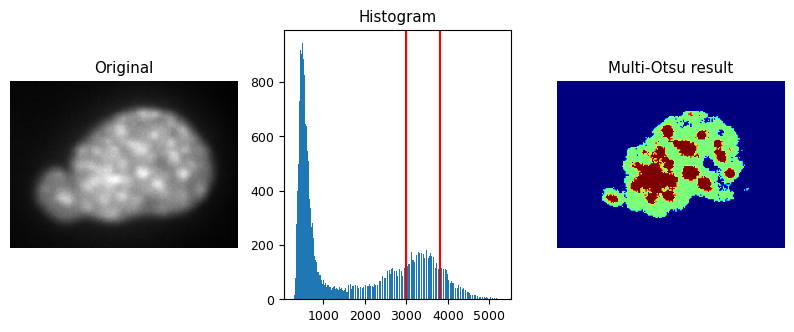

In [121]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# The input image.
# image = data.camera()
image, flat_image, normalized_image = preprocess_image(image_path)

# Applying multi-Otsu threshold for the default value, generating
# three classes.
# thresholds = threshold_multiotsu(image)
thresholds = threshold_multiotsu(masked_image)
print(thresholds)
thresholds =[3000, 3800]

# Using the threshold values, we generate the three regions.
regions = np.digitize(masked_image, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

[   1 3232]


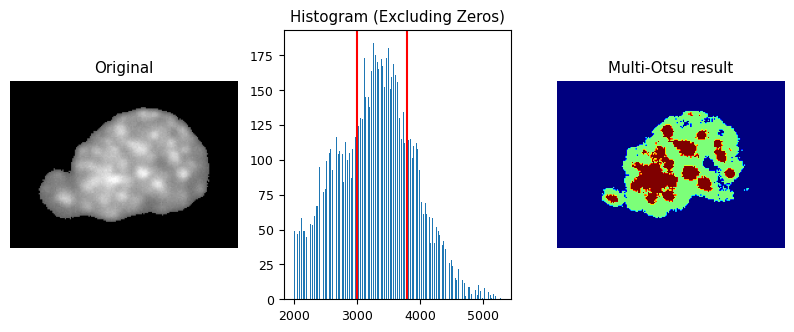

In [129]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu
import tifffile as tiff

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# Load the image (assuming preprocess_image is defined elsewhere)
# image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
# masked_image = tiff.imread(image_path)

# Applying multi-Otsu threshold for the default value, generating three classes
thresholds = threshold_multiotsu(masked_image)
print(thresholds)
thresholds =[3000, 3800]

# Using the threshold values, generate the three regions
regions = np.digitize(masked_image, bins=thresholds)

# Filter out zero values for histogram plotting
non_zero_masked_image = masked_image[masked_image > 0]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plot the original image
ax[0].imshow(masked_image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plot the histogram and the two thresholds obtained from multi-Otsu
ax[1].hist(non_zero_masked_image.ravel(), bins=255)
ax[1].set_title('Histogram (Excluding Zeros)')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plot the Multi-Otsu result
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()
plt.show()


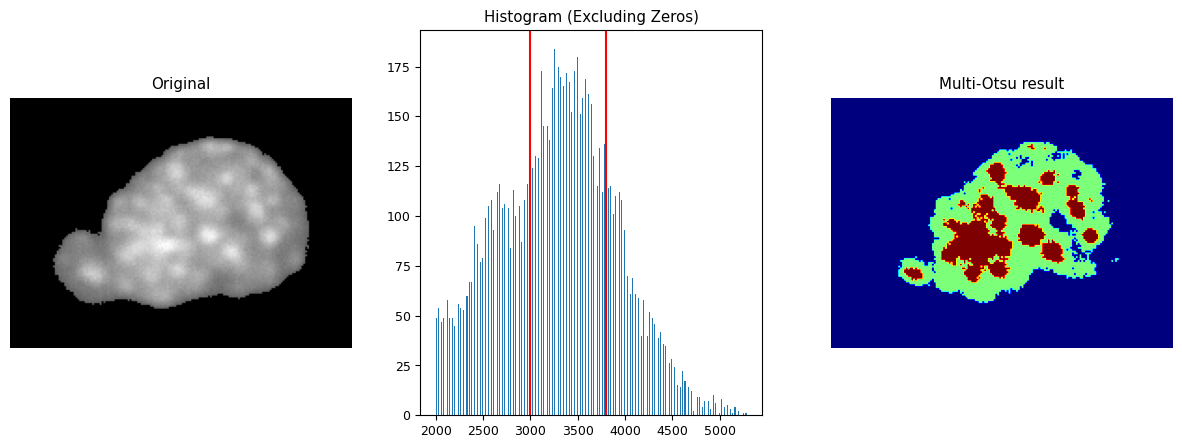

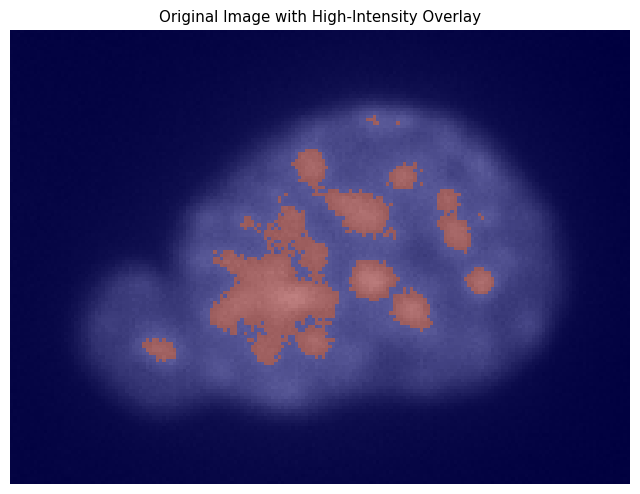

In [140]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu
import tifffile as tiff

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# Load the image
image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
image = tiff.imread(image_path)

# Applying multi-Otsu threshold for the default value, generating three classes
thresholds = threshold_multiotsu(masked_image)
thresholds =[3000, 3800]

# Using the threshold values, generate the three regions
regions = np.digitize(masked_image, bins=thresholds)

# Filter out zero values for histogram plotting
non_zero_masked_image = masked_image[masked_image > 0]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot the original image
ax[0].imshow(masked_image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plot the histogram and the two thresholds obtained from multi-Otsu
ax[1].hist(non_zero_masked_image.ravel(), bins=255)
ax[1].set_title('Histogram (Excluding Zeros)')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plot the Multi-Otsu result
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()
plt.show()

# Overlay the high-intensity regions on top of the original image
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the original image
ax.imshow(image, cmap='gray')

# Create an overlay where the highest intensity regions are shown
high_intensity_overlay = (regions == 2).astype(np.uint16)

# Use alpha blending to overlay the high-intensity regions
ax.imshow(high_intensity_overlay, cmap='jet', alpha=0.5)

ax.set_title('Original Image with High-Intensity Overlay')
ax.axis('off')

plt.show()


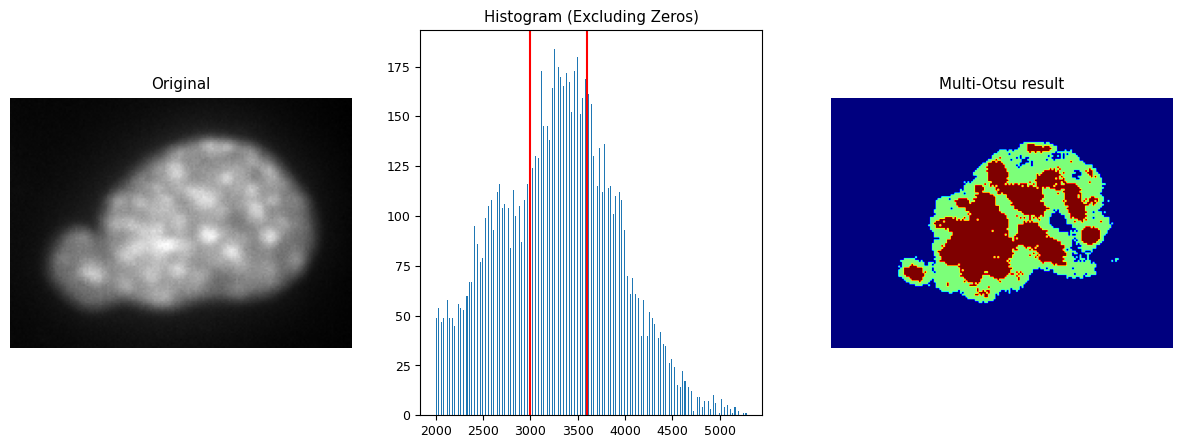

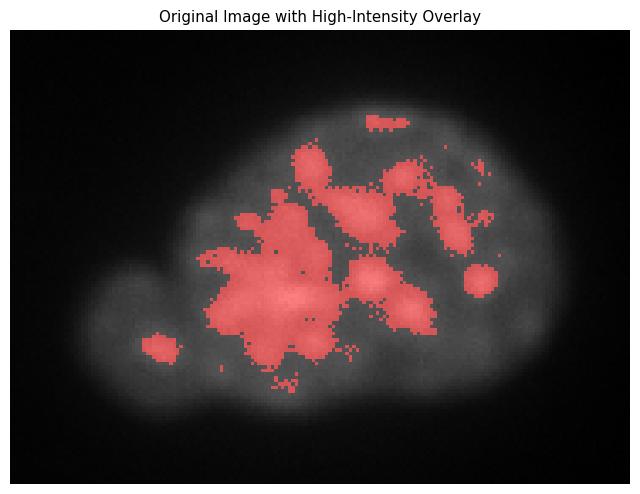

In [147]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu
import tifffile as tiff
from matplotlib.colors import LinearSegmentedColormap

# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# Load the image
image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
image = tiff.imread(image_path)

# Applying multi-Otsu threshold for the default value, generating three classes
thresholds = threshold_multiotsu(masked_image)
thresholds =[3000, 3600]

# Using the threshold values, generate the three regions
regions = np.digitize(masked_image, bins=thresholds)

# Filter out zero values for histogram plotting
non_zero_masked_image = masked_image[masked_image > 0]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot the original image
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plot the histogram and the two thresholds obtained from multi-Otsu
ax[1].hist(non_zero_masked_image.ravel(), bins=255)
ax[1].set_title('Histogram (Excluding Zeros)')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plot the Multi-Otsu result
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()
plt.show()

# Custom colormap for red overlay
red_cmap = LinearSegmentedColormap.from_list('red_cmap', ['black', 'red'], N=256)

# Overlay the high-intensity regions on top of the original image
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the original image
ax.imshow(image, cmap='gray')

# Create an overlay where the highest intensity regions are shown
high_intensity_overlay = (regions == 2).astype(np.uint16)

# Use alpha blending to overlay the high-intensity regions in red
ax.imshow(high_intensity_overlay, cmap=red_cmap, alpha=0.5)

ax.set_title('Original Image with High-Intensity Overlay')
ax.axis('off')

plt.show()


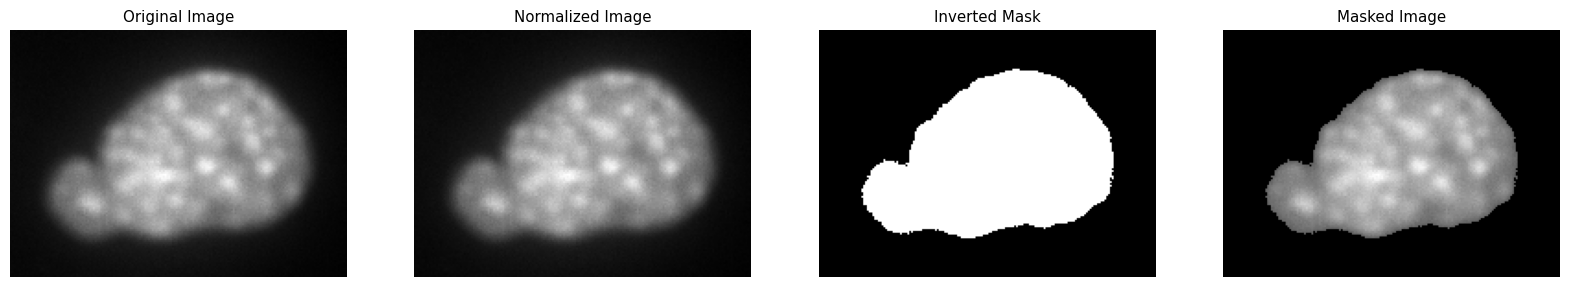

In [119]:
import tifffile as tiff
import numpy as np
import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Function to read and preprocess the TIFF image
def preprocess_image(image_path):
    # Read the image using tifffile
    image = tiff.imread(image_path)
    # Normalize the image to improve visibility
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # Flatten the image for clustering
    flat_image = normalized_image.flatten().reshape(-1, 1)
    return image, flat_image, normalized_image

# Function to apply K-means clustering to the image
def apply_kmeans(flat_image, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(flat_image)
    clustered = kmeans.labels_
    return clustered

# Function to generate an inverted binary mask from the clustered image
def generate_inverted_mask(clustered, image_shape, target_cluster=1):
    clustered_image = clustered.reshape(image_shape)
    binary_mask = (clustered_image == target_cluster).astype(np.uint8)
    inverted_mask = 1 - binary_mask  # Invert the mask
    return inverted_mask

# Function to apply the mask to the image
def apply_mask(image, mask):
    masked_image = image.copy()
    masked_image[mask == 0] = 0
    return masked_image

# Main function to process the image, generate an inverted mask, and apply the mask
def detect_and_mask_foci(image_path, n_clusters=2, target_cluster=1):
    image, flat_image, normalized_image = preprocess_image(image_path)
    clustered = apply_kmeans(flat_image, n_clusters)
    inverted_mask = generate_inverted_mask(clustered, image.shape, target_cluster)
    masked_image = apply_mask(image, inverted_mask)
    
    # Display the original, normalized, segmented, and masked images
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.title('Normalized Image')
    plt.imshow(normalized_image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.title('Inverted Mask')
    plt.imshow(inverted_mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.title('Masked Image')
    plt.imshow(masked_image, cmap='gray')
    plt.axis('off')
    
    plt.show()
    
    return masked_image

# Example usage
image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
masked_image = detect_and_mask_foci(image_path, n_clusters=2, target_cluster=1)

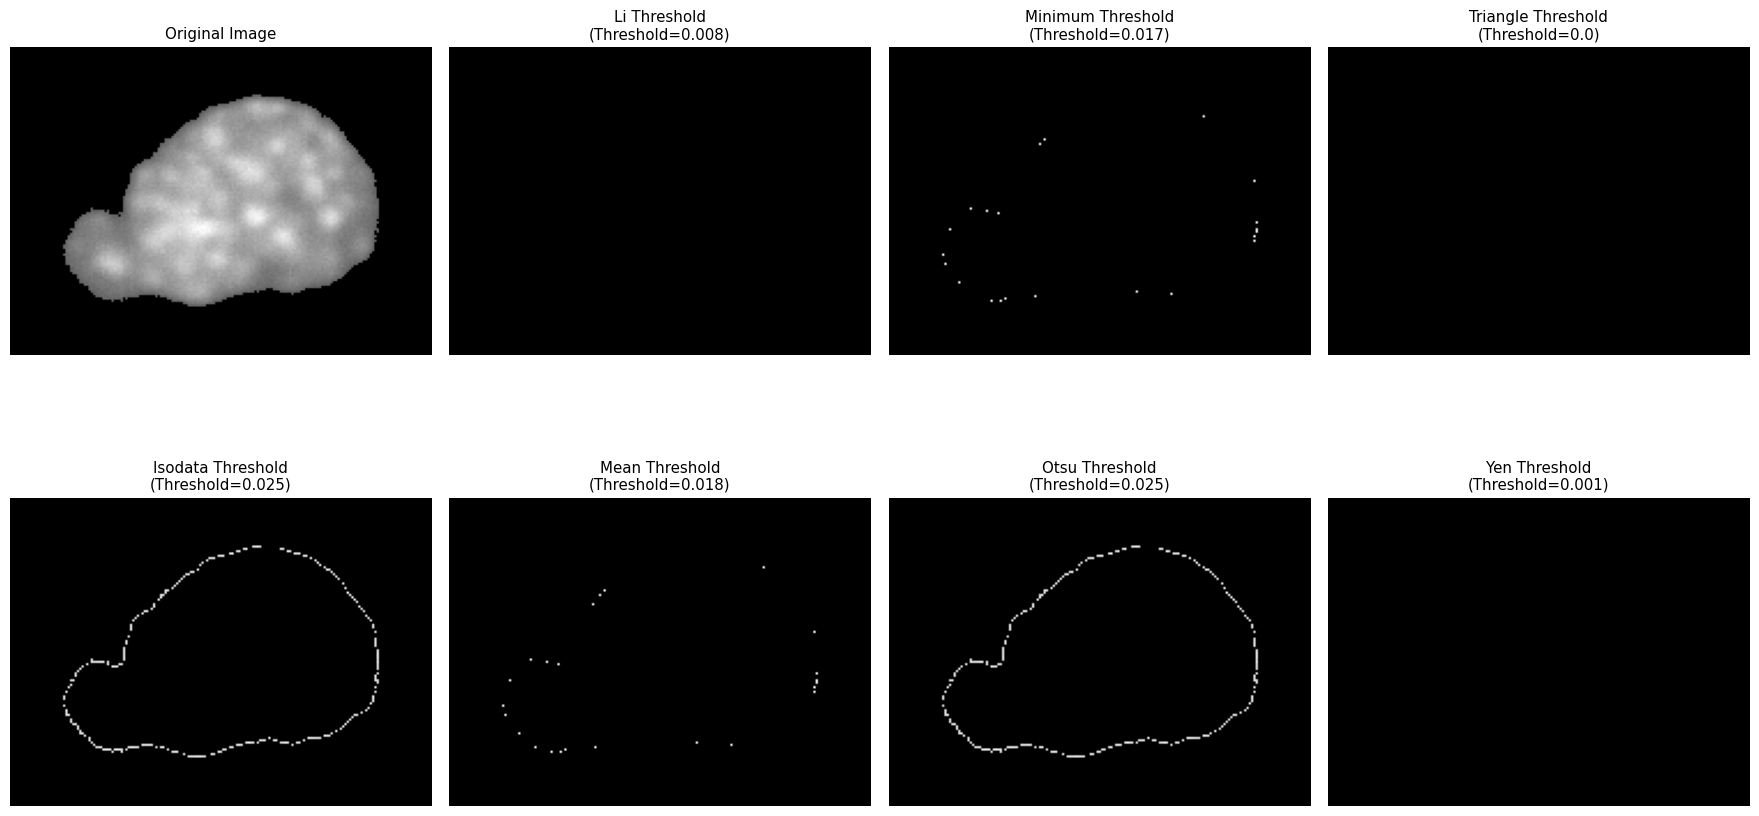

In [106]:
import skimage.io
import skimage.color
import skimage.filters
from skimage.filters import (
    threshold_li, threshold_minimum, threshold_triangle,
    threshold_isodata, threshold_mean, threshold_otsu, threshold_yen
)
import matplotlib.pyplot as plt
import numpy as np

def apply_thresh_algorithm(image):
    '''
        This function takes in an image, turns it to grayscale if needed,
        denoises it with a Gaussian filter. 
        It then calculates seven threshold values 
        corresponding to seven different algorithms for this
        grayscale image, creates masks using those values 
        and finally applies those masks to the original image.
        All masked images are plotted along with the original image 
        for comparison purposes. 
    '''
    if image.ndim == 3 and image.shape[2] == 3:  # Check if the image is RGB
        grayscale_image = skimage.color.rgb2gray(image)
    else:
        grayscale_image = image  # Image is already grayscale

    blurred_image = skimage.filters.gaussian(grayscale_image)
    
    thresh_funcs = [
        threshold_li, threshold_minimum, threshold_triangle, 
        threshold_isodata, threshold_mean, threshold_otsu, threshold_yen
    ]
    
    algorithm_name = []
    
    # Plot the Original and masked images:
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 10), sharex=True, sharey=True)
    ax = ax.ravel()
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    
    for count, func in enumerate(thresh_funcs, start=1):
        thresh = func(blurred_image)
        mask = blurred_image < thresh
        selection = np.zeros_like(image)
        selection[mask] = image[mask]
        algorithm_name.append(func.__name__.split('_')[1].title())
        ax[count].imshow(selection, cmap='gray')
        ax[count].set_title(f'{algorithm_name[-1]} Threshold\n(Threshold={round(thresh, 3)})')
    
    plt.tight_layout()
    for a in ax:
        a.axis('off')
    
    plt.show()

# Example usage
image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
# masked_image = detect_and_mask_foci(image_path, n_clusters=2, target_cluster=1)

apply_thresh_algorithm(masked_image)


0.2219246762436225


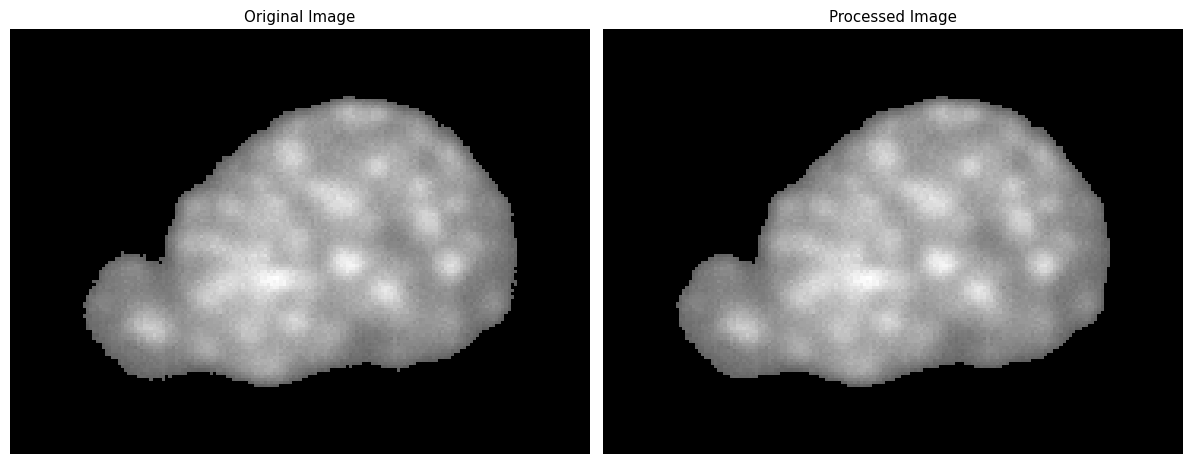

In [89]:
import skimage.io
import skimage.filters
import skimage.color
import matplotlib.pyplot as plt
import numpy as np

# Function to apply Gaussian filter and threshold
def apply_Gaussian_thresh(image):
    '''
        This function takes in an image, denoises it with a Gaussian
        filter, creates a mask with a threshold based on the mean intensity,
        and returns an image with objects whose values are greater than the threshold.
    '''
    # Normalize the image to the range [0, 1] if it's not already normalized
    if image.dtype == np.uint16:
        image = image / np.max(image)
    
    blurred_image = skimage.filters.gaussian(image, sigma=1.0)
    threshold = np.mean(blurred_image)  # Use mean intensity as threshold
    print(threshold)
    #threshold = 0.302893109442813
    threshold = 0.2219
    binary_mask = blurred_image > threshold
    selection = np.zeros_like(image)
    selection[binary_mask] = image[binary_mask]
    return selection

# Assuming 'masked_image' is the image you want to process
# image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
# masked_image = tiff.imread(image_path)

# Apply Gaussian filter and threshold to the image
processed_image = apply_Gaussian_thresh(masked_image)

# Plot the original and processed images
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=True, sharey=True)

# Original image
ax[0].imshow(masked_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Processed image
ax[1].imshow(processed_image, cmap='gray')
ax[1].set_title('Processed Image')
ax[1].axis('off')

plt.tight_layout()
plt.show()


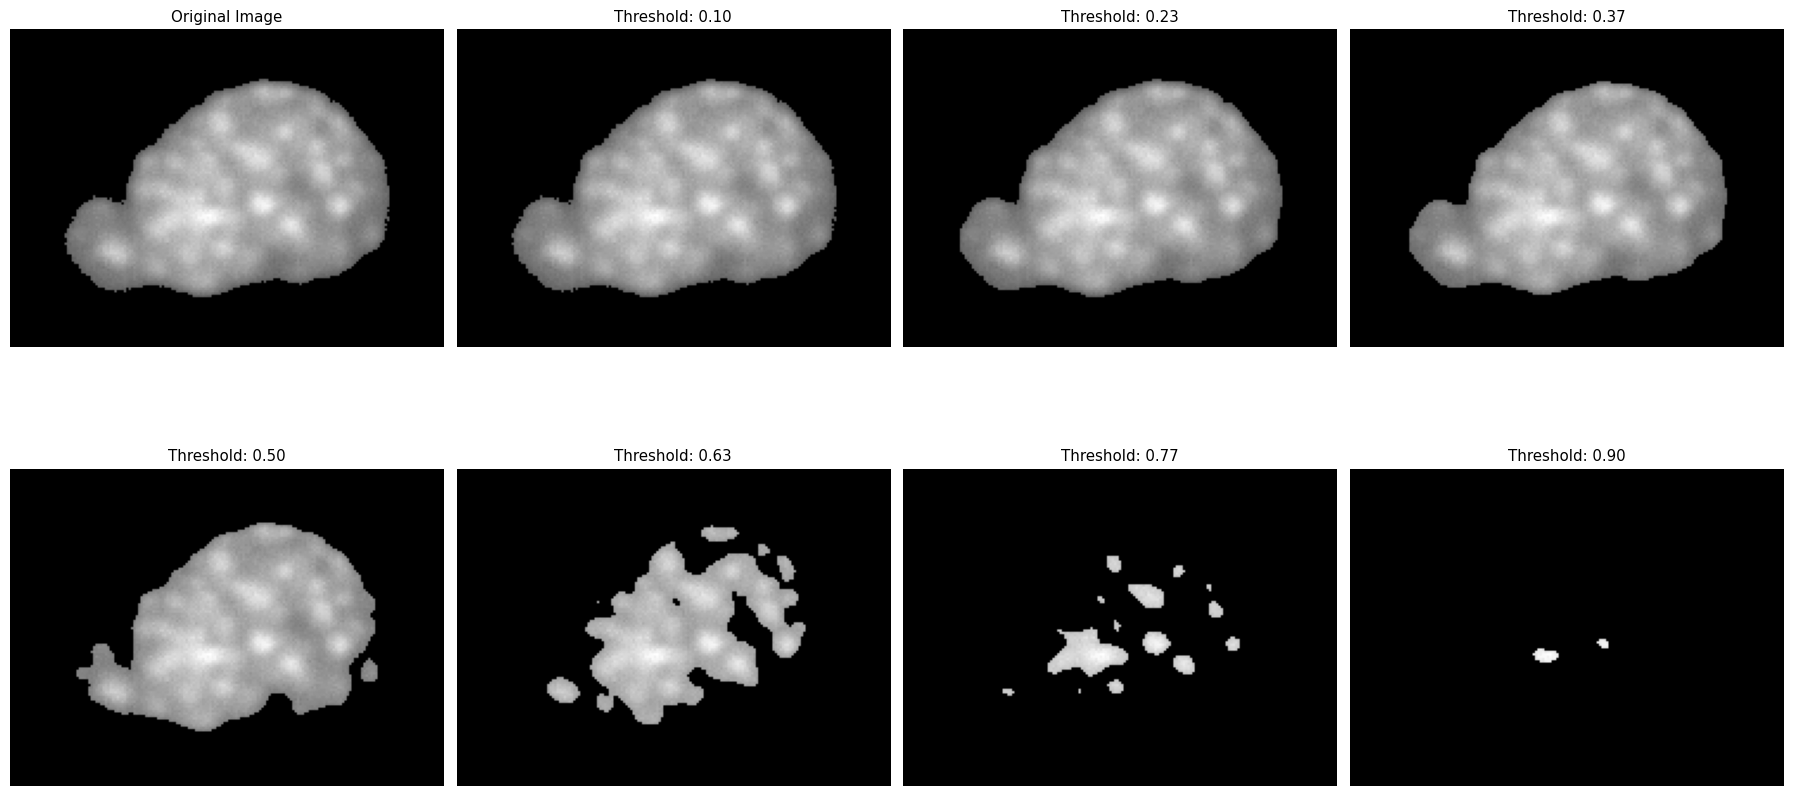

In [104]:
import skimage.io
import skimage.filters
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

# Function to apply Gaussian filter and a given threshold
def apply_gaussian_and_threshold(image, threshold):
    '''
        This function takes in an image, denoises it with a Gaussian
        filter, creates a mask with a given threshold value, and returns
        an image with objects whose values are greater than the threshold.
    '''
    # Normalize the image to the range [0, 1] if it's not already normalized
    if image.dtype == np.uint16:
        image = image / np.max(image)
    
    blurred_image = skimage.filters.gaussian(image, sigma=1.0)
    binary_mask = blurred_image > threshold
    selection = np.zeros_like(image)
    selection[binary_mask] = image[binary_mask]
    return selection

# Load the image
# image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
# masked_image = tiff.imread(image_path)

# Define a range of threshold values to test
threshold_values = np.linspace(0.1, 0.9, 7)

# Plot the original and processed images for different threshold values
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 10), sharex=True, sharey=True)
ax = ax.ravel()

# Original image
ax[0].imshow(masked_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Processed images with different thresholds
for i, threshold in enumerate(threshold_values, start=1):
    processed_image = apply_gaussian_and_threshold(masked_image, threshold)
    ax[i].imshow(processed_image, cmap='gray')
    ax[i].set_title(f'Threshold: {threshold:.2f}')
    ax[i].axis('off')

# Remove any unused subplots
for j in range(len(threshold_values) + 1, len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()


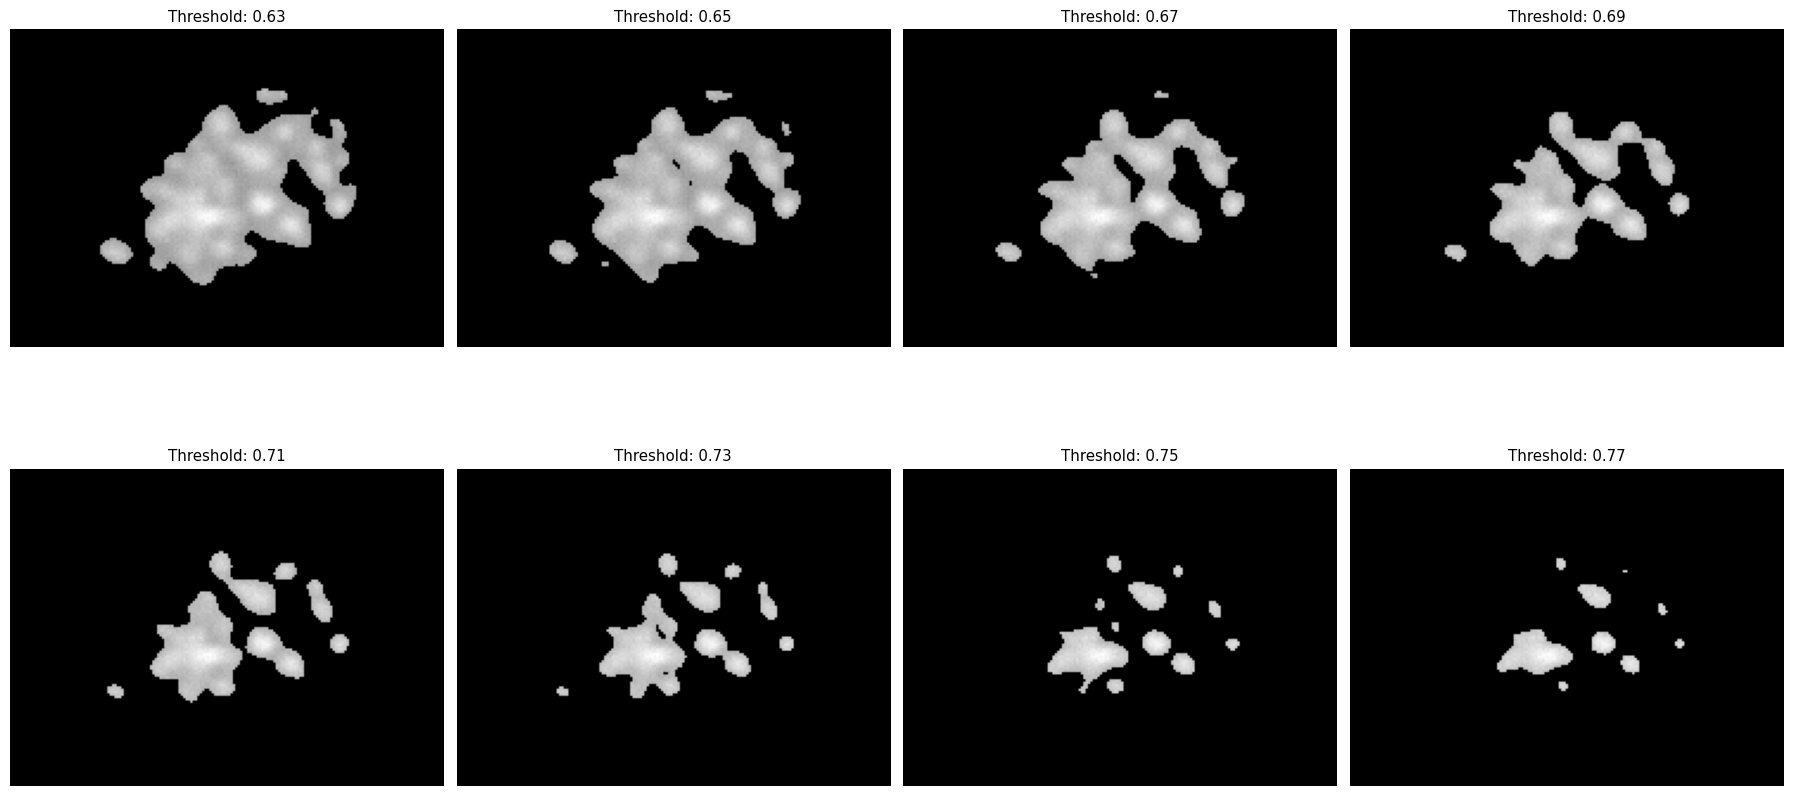

In [102]:
import skimage.io
import skimage.filters
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

# Function to apply Gaussian filter and a given threshold
def apply_gaussian_and_threshold(image, threshold):
    '''
        This function takes in an image, denoises it with a Gaussian
        filter, creates a mask with a given threshold value, and returns
        an image with objects whose values are greater than the threshold.
    '''
    # Normalize the image to the range [0, 1] if it's not already normalized
    if image.dtype == np.uint16:
        image = image / np.max(image)
    
    blurred_image = skimage.filters.gaussian(image, sigma=2)
    binary_mask = blurred_image > threshold
    selection = np.zeros_like(image)
    selection[binary_mask] = image[binary_mask]
    return selection

# Load the image
# image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
# masked_image = tiff.imread(image_path)

# Define a narrower range of threshold values to test (between 0.63 and 0.77)
threshold_values = np.linspace(0.63, 0.77, 8)

# Plot the original and processed images for different threshold values
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 10), sharex=True, sharey=True)
ax = ax.ravel()

# Original image
ax[0].imshow(masked_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Processed images with different thresholds
for i, threshold in enumerate(threshold_values, start=0):
    processed_image = apply_gaussian_and_threshold(masked_image, threshold)
    ax[i].imshow(processed_image, cmap='gray')
    ax[i].set_title(f'Threshold: {threshold:.2f}')
    ax[i].axis('off')

# Remove any unused subplots
for j in range(len(threshold_values) + 1, len(ax)):
    ax[j].axis('off')

plt.tight_layout()
plt.show()
